# APRENDIZAJE PROFUNDO Y SERIES TEMPORALES

## por: Marco Cajamarca, Adrian Campoverde y Pablo Bravo

A continuación, se desarrollará una función que utiliza una para predecir la demanda de productos a partir de datos históricos reales. Este enfoque permitirá anticipar las necesidades de inventario y tomar decisiones informadas basadas en el comportamiento temporal de las ventas. 

`source ~/tf-env/bin/activate`
`mlflow ui --backend-store-uri file:mlruns`

In [7]:
# Imports
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Concatenate
from IPython.display import display
import mlflow
import joblib
import os


# Configuracion de mlflow

In [8]:
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
mlflow_tracking_dir = os.path.join(notebook_dir, 'mlruns')

os.makedirs(mlflow_tracking_dir, exist_ok=True)

mlflow.set_tracking_uri(f'file://{mlflow_tracking_dir}')

experiment_name = 'stock_demand_forecasting'
mlflow.set_experiment(experiment_name)

# Obtener información del experimento
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"Experimento: {experiment_name}")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Directorio MLflow: {mlflow_tracking_dir}")
print(f"Experiment ID: {experiment.experiment_id}")

mlflow.keras.autolog(log_models=True, log_datasets=True, disable=False, exclusive=False)

print("\n✅ MLflow configurado correctamente")
print("💡 Para ver la UI, ejecuta en terminal: mlflow ui --backend-store-uri file://./mlruns")

Experimento: stock_demand_forecasting
Tracking URI: file:///home/adrian/Desktop/test/aprendizaje/mlruns
Directorio MLflow: /home/adrian/Desktop/test/aprendizaje/mlruns
Experiment ID: 120979648417389380

✅ MLflow configurado correctamente
💡 Para ver la UI, ejecuta en terminal: mlflow ui --backend-store-uri file://./mlruns


### configuracion básica de tensorflow para uso optimo de gpu

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("GPU config error:", e)

# Habilitar XLA JIT para acelerar operaciones
tf.config.optimizer.set_jit(True)

# Ajustar hilos para aprovechar CPU en preprocesamiento
ncpu = os.cpu_count() or 4
tf.config.threading.set_intra_op_parallelism_threads(ncpu)
tf.config.threading.set_inter_op_parallelism_threads(ncpu)


# Fase 1:
Análisis y Preparación del Dataset

Objetivo:
Cargar, explorar y preparar el dataset para el entrenamiento de modelos de aprendizaje profundo.
En esta fase se realiza una inspección inicial de los datos, identificación de valores faltantes, análisis de las variables y creación de características temporales relevantes para el modelado de series temporales.

In [10]:
# Cargar el archivo CSV real
ruta = Path('practica_completo.csv')
df = pd.read_csv(ruta)

# Mostrar columnas y primeras filas
print("Columnas:", df.columns.tolist())
display(df.head())

# Tipos de datos y valores faltantes
print("\nTipos de datos:")
display(df.dtypes)
print("\nValores faltantes por columna:")
display(df.isnull().sum())

# Mostrar rango de fechas del dataset
print("Primer registro:", df['created_at'].min())
print("Último registro:", df['created_at'].max())

Columnas: ['id', 'created_at', 'product_id', 'product_name', 'product_sku', 'quantity_on_hand', 'last_order_date', 'unit_cost', 'shelf_location', 'notes', 'entrada', 'salida', 'detalle']


,id,created_at,product_id,product_name,product_sku,quantity_on_hand,last_order_date,unit_cost,shelf_location,notes,entrada,salida,detalle
0,38681,2022-08-12 14:07:42,362,CREMA LUBRIDERM 200 ML FPS 15,7702035416155,2.0,2022-08-12 14:07:42,6.25,VITRINA PONDS,S/N\r\n,0.0,1.0,Factura 001-050-000000008
1,38684,2022-08-12 20:25:52,363,CREMA JOHNSONS BABY,7891010035617,5.0,2022-08-12 20:25:52,2.50,VITRINA PONDS,S/N\r\n,0.0,1.0,Nota de venta 001-050-000000008
2,38685,2022-08-12 20:29:30,363,CREMA JOHNSONS BABY,7891010035617,4.0,2022-08-12 20:29:30,2.50,VITRINA PONDS,S/N\r\n,0.0,1.0,Nota de venta 001-050-000000009
3,38689,2022-08-13 11:07:35,375,CREMA NIVEA 30ML,4005800137655,36.0,2022-08-13 11:07:35,1.40,VITRINA PONDS,S/N\r\n,0.0,1.0,Nota de venta 001-050-000000010
4,38706,2022-08-14 13:48:16,375,CREMA NIVEA 30ML,4005800137655,34.0,2022-08-14 13:48:16,1.40,VITRINA PONDS,S/N\r\n,0.0,2.0,Nota de venta 001-050-000000011



Tipos de datos:


id                    int64
created_at           object
product_id            int64
product_name         object
product_sku          object
quantity_on_hand    float64
last_order_date      object
unit_cost           float64
shelf_location       object
notes                object
entrada             float64
salida              float64
detalle              object
dtype: object


Valores faltantes por columna:


id                      0
created_at              0
product_id              0
product_name            0
product_sku             0
quantity_on_hand        0
last_order_date         0
unit_cost               0
shelf_location          0
notes               15179
entrada                 0
salida                  0
detalle                 0
dtype: int64

Primer registro: 2022-08-12 14:07:42
Último registro: 2025-10-13 16:23:05


In [11]:
# Eliminar filas con valores nulos críticos
df = df.dropna(subset=['created_at', 'product_id', 'salida'])

# Eliminar duplicados si existen
df = df.drop_duplicates()

# Convertir fechas a datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['last_order_date'] = pd.to_datetime(df['last_order_date'], errors='coerce')

# Revisar valores extremos en ventas
print("Ventas (salida) - resumen estadístico:")
display(df['salida'].describe())

Ventas (salida) - resumen estadístico:


count    330856.000000
mean          1.345826
std           1.317303
min          -1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          19.000000
Name: salida, dtype: float64

In [12]:
# Crear variables temporales
df['dia_semana'] = df['created_at'].dt.dayofweek
df['mes'] = df['created_at'].dt.month
df['fin_semana'] = df['dia_semana'].isin([5,6]).astype(int)

# Feriados (ajusta según tu país)
feriados = [
    '2024-01-01', '2024-02-12', '2024-02-13', '2024-03-29', '2024-05-01',
    '2024-05-24', '2024-08-10', '2024-10-09', '2024-11-02', '2024-11-03', '2024-12-25'
]
df['fecha'] = df['created_at'].dt.date.astype(str)
df['feriado'] = df['fecha'].isin(feriados).astype(int)

# Antigüedad del producto (en días)
df['antiguedad_producto'] = (df['created_at'] - df.groupby('product_id')['created_at'].transform('min')).dt.days

# Ratio vendida/stock (si aplica)
df['ratio_vendida_stock'] = df['salida'] / (df['quantity_on_hand'] + 1e-6)

# Mostrar ejemplo
display(df.head())

,id,created_at,product_id,product_name,product_sku,quantity_on_hand,last_order_date,unit_cost,shelf_location,notes,entrada,salida,detalle,dia_semana,mes,fin_semana,fecha,feriado,antiguedad_producto,ratio_vendida_stock
0,38681,2022-08-12 14:07:42,362,CREMA LUBRIDERM 200 ML FPS 15,7702035416155,2.0,2022-08-12 14:07:42,6.25,VITRINA PONDS,S/N\r\n,0.0,1.0,Factura 001-050-000000008,4,8,0,2022-08-12,0,0,0.500000
1,38684,2022-08-12 20:25:52,363,CREMA JOHNSONS BABY,7891010035617,5.0,2022-08-12 20:25:52,2.50,VITRINA PONDS,S/N\r\n,0.0,1.0,Nota de venta 001-050-000000008,4,8,0,2022-08-12,0,0,0.200000
2,38685,2022-08-12 20:29:30,363,CREMA JOHNSONS BABY,7891010035617,4.0,2022-08-12 20:29:30,2.50,VITRINA PONDS,S/N\r\n,0.0,1.0,Nota de venta 001-050-000000009,4,8,0,2022-08-12,0,0,0.250000
3,38689,2022-08-13 11:07:35,375,CREMA NIVEA 30ML,4005800137655,36.0,2022-08-13 11:07:35,1.40,VITRINA PONDS,S/N\r\n,0.0,1.0,Nota de venta 001-050-000000010,5,8,1,2022-08-13,0,0,0.027778
4,38706,2022-08-14 13:48:16,375,CREMA NIVEA 30ML,4005800137655,34.0,2022-08-14 13:48:16,1.40,VITRINA PONDS,S/N\r\n,0.0,2.0,Nota de venta 001-050-000000011,6,8,1,2022-08-14,0,1,0.058824


In [13]:
# Variables a usar en la secuencia
features = ['salida', 'dia_semana', 'mes', 'fin_semana', 'feriado', 'quantity_on_hand', 'unit_cost']
ventana = 7  # días de historial

def crear_ventanas_con_producto(df, features, ventana=7):
    """Crea secuencias manteniendo el product_id y prediciendo stock"""
    X_seq, y_stock, product_ids, fechas = [], [], [], []
    
    for product_id, grupo in df.groupby('product_id'):
        grupo = grupo.sort_values('created_at')
        datos = grupo[features].values
        stock = grupo['quantity_on_hand'].values
        fechas_grupo = grupo['created_at'].values
        
        for i in range(len(datos) - ventana):
            X_seq.append(datos[i:i+ventana])
            y_stock.append(stock[i+ventana])
            product_ids.append(product_id)
            fechas.append(fechas_grupo[i+ventana])
    
    return np.array(X_seq), np.array(y_stock), np.array(product_ids), np.array(fechas)

X_seq, y_seq, product_ids, fechas = crear_ventanas_con_producto(df, features, ventana=ventana)
print("Forma de X_seq:", X_seq.shape)
print("Forma de y_seq (stock):", y_seq.shape)
print("Productos únicos:", len(np.unique(product_ids)))


Forma de X_seq: (230229, 7, 7)
Forma de y_seq (stock): (230229,)
Productos únicos: 9001


# Fase 2:
## Desarrollo y Entrenamiento del Modelo

### Objetivo:
Implementar un modelo de Deep Learning usando RNN (por ejemplo, LSTM o GRU) para predecir la demanda futura.

Limpieza y normalizacion de datos

In [14]:
from sklearn.preprocessing import RobustScaler
from scipy import stats

n_samples, ventana, n_features = X_seq.shape

# Filtrar productos con stock muy bajo o cero
print(f"📊 Filtrando datos con stock bajo...")
print(f"   Muestras originales: {len(y_seq)}")
mask_stock_valido = y_seq >= 10  # Solo stock >= 10 unidades
X_seq_filtrado = X_seq[mask_stock_valido]
y_seq_filtrado = y_seq[mask_stock_valido]
product_ids_filtrado = product_ids[mask_stock_valido]
print(f"   Muestras después de filtrar (stock >= 10): {len(y_seq_filtrado)}")
print(f"   Removidos: {len(y_seq) - len(y_seq_filtrado)} ({(len(y_seq) - len(y_seq_filtrado))/len(y_seq)*100:.2f}%)")

# Transformación logarítmica del target para mejorar distribución
y_seq_log = np.log1p(y_seq_filtrado)  # log(1 + x) para evitar log(0)

# Codificar product_ids
le = LabelEncoder()
product_ids_encoded = le.fit_transform(product_ids_filtrado)
joblib.dump(le, 'product_encoder.joblib')

# Normalizar secuencias
scaler = RobustScaler()
X_seq_reshaped = X_seq_filtrado.reshape(-1, n_features)
X_seq_scaled = scaler.fit_transform(np.nan_to_num(X_seq_reshaped, nan=0))
X_seq_scaled = X_seq_scaled.reshape(-1, ventana, n_features)

# Split inicial con target logarítmico
X_train_raw, X_val, y_train_log_raw, y_val_log, pid_train_raw, pid_val = train_test_split(
    X_seq_scaled, y_seq_log, product_ids_encoded, test_size=0.2, random_state=42
)

# Eliminar outliers en escala logarítmica (más suave)
z_scores = np.abs(stats.zscore(y_train_log_raw))
mask_no_outliers = z_scores < 3.5
X_train = X_train_raw[mask_no_outliers]
y_train_log = y_train_log_raw[mask_no_outliers]
pid_train = pid_train_raw[mask_no_outliers]

outliers_removed = len(y_train_log_raw) - len(y_train_log)
print(f"\n📊 Limpieza de outliers:")
print(f"   Outliers removidos: {outliers_removed} ({outliers_removed/len(y_train_log_raw)*100:.2f}%)")
print(f"   Train: {len(y_train_log)}, Val: {len(y_val_log)}")
print(f"   Stock (escala log) - Min: {y_train_log.min():.3f}, Max: {y_train_log.max():.3f}, Media: {y_train_log.mean():.3f}")
print(f"   Stock (escala real) - Min: {np.expm1(y_train_log).min():.1f}, Max: {np.expm1(y_train_log).max():.1f}")


📊 Filtrando datos con stock bajo...
   Muestras originales: 230229
   Muestras después de filtrar (stock >= 10): 178779
   Removidos: 51450 (22.35%)

📊 Limpieza de outliers:
   Outliers removidos: 254 (0.18%)
   Train: 142769, Val: 35756
   Stock (escala log) - Min: 2.398, Max: 9.517, Media: 4.451
   Stock (escala real) - Min: 10.0, Max: 13585.0


# Creación del modelo con embedding de productos


I0000 00:00:1763661815.810109  179114 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6111 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


2025/11/20 13:03:36 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2025/11/20 13:03:36 WARNING mlflow.keras.autologging: Failed to log dataset information to MLflow. Reason: 'list' object has no attribute 'flatten'



Run ID: 21c5f74e642f401286ea035ac3892aa1
Estrategia: Weighted Loss - Stock alto (>=200) peso 2.5x, medio (50-200) peso 1.5x


Epoch 1/150


2025-11-20 13:03:38.437973: I external/local_xla/xla/service/service.cc:163] XLA service 0x19454ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-20 13:03:38.437989: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-11-20 13:03:38.453547: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1763661818.501615  180182 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-20 13:03:40.644166: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-20 13:03:41.281629: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. May

558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8131 - mae: 0.8197 - rmse: 1.2033
Epoch 1: val_loss improved from None to 0.10134, saving model to best_model_v2.keras
558/558 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.3647 - mae: 0.4799 - rmse: 0.7600 - val_loss: 0.1013 - val_mae: 0.1786 - val_rmse: 0.2679
Epoch 2/150
555/558 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1675 - mae: 0.3016 - rmse: 0.3935

2025-11-20 13:03:55.427392: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-20 13:03:55.427414: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-20 13:03:55.427424: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-20 13:03:55.427436: I external/l

558/558 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1675 - mae: 0.3015 - rmse: 0.3935

2025-11-20 13:03:58.734781: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-20 13:03:58.734803: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-20 13:03:58.960004: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_149', 4 bytes spill stores, 4 bytes spill loads

2025-11-20 13:03:59.155654: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re


Epoch 2: val_loss did not improve from 0.10134
558/558 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1579 - mae: 0.2905 - rmse: 0.3806 - val_loss: 0.1257 - val_mae: 0.2251 - val_rmse: 0.3097
Epoch 3/150
554/558 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1313 - mae: 0.2566 - rmse: 0.3421
Epoch 3: val_loss did not improve from 0.10134
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1308 - mae: 0.2580 - rmse: 0.3429 - val_loss: 0.1257 - val_mae: 0.2519 - val_rmse: 0.3326
Epoch 4/150
552/558 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1203 - mae: 0.2493 - rmse: 0.3308
Epoch 4: val_loss improved from 0.10134 to 0.09426, saving model to best_model_v2.keras
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1159 - mae: 0.2431 - rmse: 0.3248 - val_loss: 0.0943 - val_mae: 0.1924 - val_rmse: 0.2778
Epoch 5/150
556/558 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1035 - mae: 0.2275 - rmse: 0.3059
Epoch 5: val_loss did not improve from 0.09426
558/558 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1002

2025/11/20 13:09:26 WARNING mlflow.keras.autologging: Failed to get model signature, reason: Creating Schema with multiple unnamed TensorSpecs is not supported. Please provide names for each TensorSpec.
2025/11/20 13:09:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 13:09:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/20 13:09:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpfuilf121/model, flavor: keras). Fall back to return ['keras==3.12.0']. Set logging level to DEBUG to see the full traceback. 
2025/11/20 13:09:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


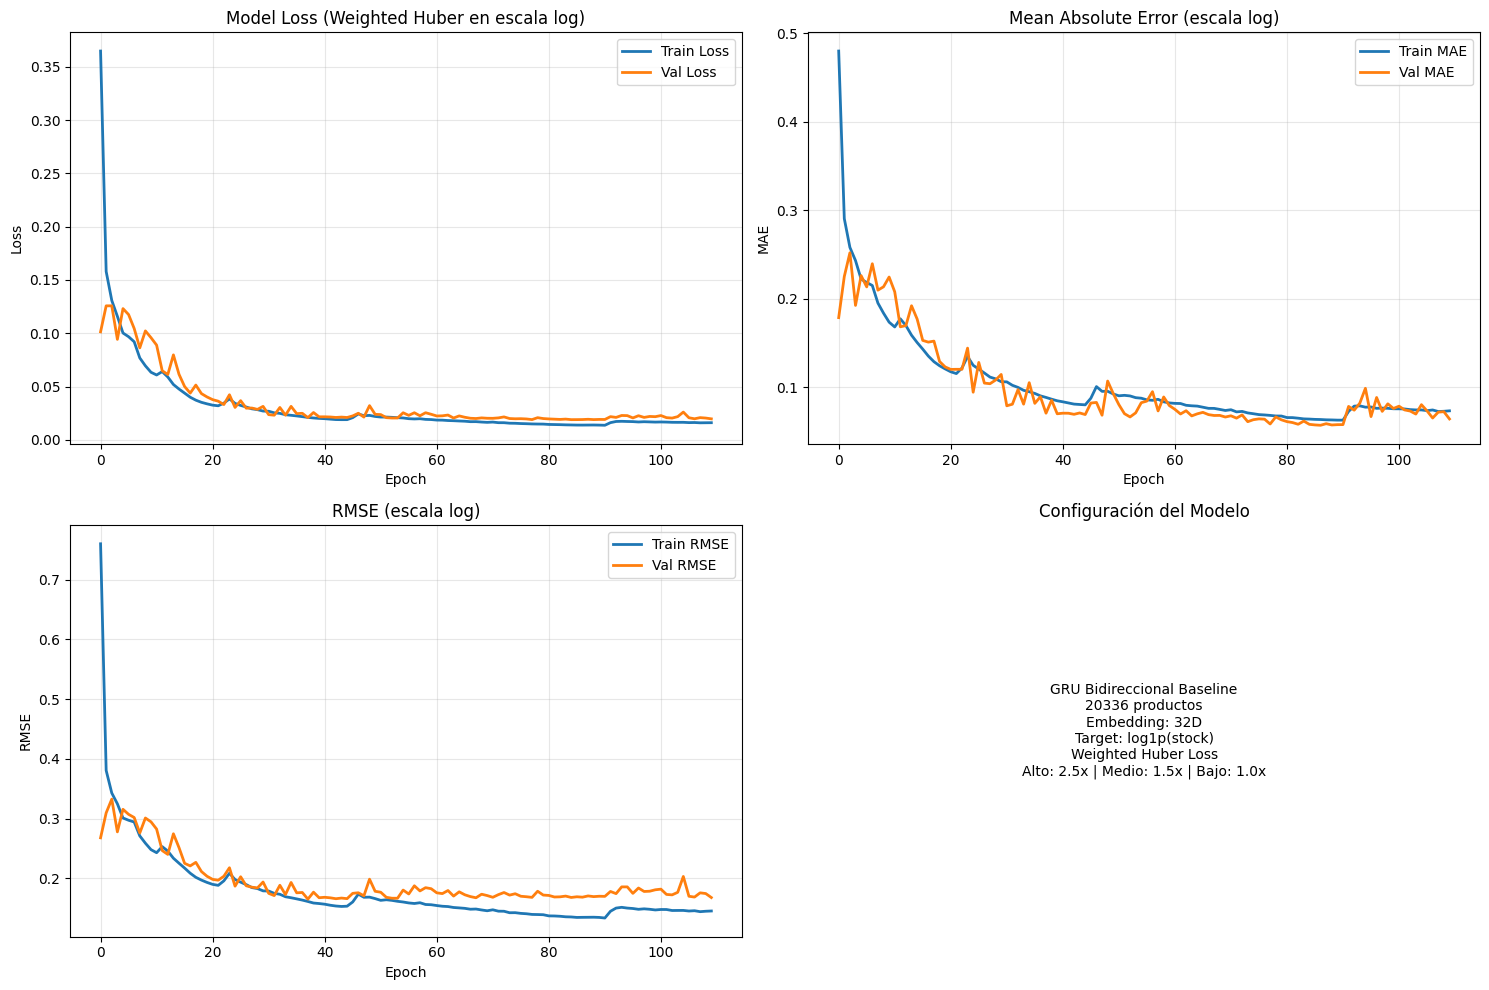

In [15]:
n_productos = len(df['product_id'].unique())
embedding_dim = 32  # Baseline dimension

# Input de secuencia temporal
seq_input = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]), name='sequence')
product_input = keras.layers.Input(shape=(1,), name='product_id')

# Embedding del producto
product_embedding = Embedding(
    input_dim=n_productos + 1,
    output_dim=embedding_dim,
    name='product_embedding'
)(product_input)
product_embedding = keras.layers.Flatten()(product_embedding)

# Procesamiento de secuencia temporal - arquitectura baseline simplificada
x = keras.layers.Bidirectional(keras.layers.GRU(
    128, 
    return_sequences=True,
    kernel_regularizer=keras.regularizers.l2(0.0001)
))(seq_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Bidirectional(keras.layers.GRU(
    64, 
    return_sequences=False,
    kernel_regularizer=keras.regularizers.l2(0.0001)
))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

# Combinar información de producto + secuencia temporal
combined = Concatenate()([x, product_embedding])

# Capas densas
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(combined)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation='relu')(x)

# Output en escala logarítmica
output = keras.layers.Dense(1, name='stock_log_predicho')(x)

model = keras.Model(inputs=[seq_input, product_input], outputs=output)

# Custom weighted loss que da más importancia a valores altos de stock
@tf.function
def weighted_huber_loss(y_true, y_pred, delta=1.0, high_stock_threshold=5.3):
    """
    Huber loss con pesos adaptativos basados en el valor del stock (en escala log)
    high_stock_threshold en escala log: log1p(200) ≈ 5.3
    """
    # Calcular error
    error = y_true - y_pred
    abs_error = tf.abs(error)
    
    # Huber loss básico
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = 0.5 * quadratic**2 + delta * linear
    
    # Calcular pesos adaptativos: mayor peso para stock alto
    # Stock alto (log >= 5.3): peso 2.5x
    # Stock medio (log 3.9-5.3): peso 1.5x  
    # Stock bajo (log < 3.9): peso 1.0x
    weights = tf.where(
        y_true >= high_stock_threshold,
        2.5,  # Stock >= 200 unidades (log1p(200) ≈ 5.3)
        tf.where(
            y_true >= 3.9,  # Stock >= 50 unidades (log1p(50) ≈ 3.9)
            1.5,
            1.0
        )
    )
    
    # Aplicar pesos a la loss
    weighted_loss = loss * weights
    
    return tf.reduce_mean(weighted_loss)

# Learning rate schedule más conservador
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=100,
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.0001
)

optimizer = keras.optimizers.Adam(
    learning_rate=lr_schedule,
    clipnorm=1.0
)

# Compilar con loss personalizada
model.compile(
    optimizer=optimizer, 
    loss=weighted_huber_loss,
    metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=25,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-5,
    mode='min'
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_v2.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)

run_params = {
    'ventana': ventana,
    'n_features': n_features,
    'n_productos': n_productos,
    'embedding_dim': embedding_dim,
    'architecture': 'Baseline_BiGRU_WeightedLoss',
    'total_params': model.count_params(),
    'optimizer': 'adam_with_cosine_decay',
    'initial_learning_rate': initial_learning_rate,
    'loss_function': 'weighted_huber',
    'loss_weights': 'high_stock_2.5x_medium_1.5x_low_1.0x',
    'target_transform': 'log1p',
    'output_activation': 'linear',
    'scaler': 'RobustScaler',
    'outlier_removal': 'z_score_3.5',
    'min_stock_threshold': 10,
    'outliers_removed': outliers_removed,
    'batch_size': 256,
    'epochs': 150,
    'prediction_target': 'quantity_on_hand_log',
    'enhancements': 'weighted_loss_for_high_stock+batch_norm'
}

with mlflow.start_run(run_name=f'stock_weighted_{datetime.now().strftime("%Y%m%d_%H%M%S")}') as run:
    mlflow.log_params(run_params)
    mlflow.log_param('train_samples', len(X_train))
    mlflow.log_param('val_samples', len(X_val))
    
    model_summary = []
    model.summary(print_fn=lambda x: model_summary.append(x))
    model_summary_str = '\n'.join(model_summary)
    
    with open('model_summary.txt', 'w') as f:
        f.write(model_summary_str)
    mlflow.log_artifact('model_summary.txt')
    
    print(f"\nRun ID: {run.info.run_id}")
    print(f"Estrategia: Weighted Loss - Stock alto (>=200) peso 2.5x, medio (50-200) peso 1.5x")
    
    history = model.fit(
        [X_train, pid_train],
        y_train_log,
        validation_data=([X_val, pid_val], y_val_log),
        epochs=run_params['epochs'],
        batch_size=run_params['batch_size'],
        callbacks=[early_stopping, model_checkpoint, tensorboard],
        verbose=1,
        shuffle=True
    )
    
    scaler_path = 'scaler.joblib'
    joblib.dump(scaler, scaler_path)
    mlflow.log_artifact(scaler_path)
    mlflow.log_artifact('product_encoder.joblib')
    
    if os.path.exists('best_model_v2.keras'):
        mlflow.log_artifact('best_model_v2.keras')
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss (Weighted Huber en escala log)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
    axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    axes[0, 1].set_title('Mean Absolute Error (escala log)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(history.history['rmse'], label='Train RMSE', linewidth=2)
    axes[1, 0].plot(history.history['val_rmse'], label='Val RMSE', linewidth=2)
    axes[1, 0].set_title('RMSE (escala log)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('RMSE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].text(0.5, 0.5, 
                   f'GRU Bidireccional Baseline\n{n_productos} productos\nEmbedding: {embedding_dim}D\nTarget: log1p(stock)\nWeighted Huber Loss\nAlto: 2.5x | Medio: 1.5x | Bajo: 1.0x', 
                   ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=10)
    axes[1, 1].set_title('Configuración del Modelo')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('training_history.png')
    plt.show()


🔬 Evaluando modelo en conjunto de validación...
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

📊 Métricas Finales (Predicción de Stock):
  RMSE: 154.07
  MAE: 20.38
  Median AE: 1.51
  MAPE (stock >= 10): 6.45%
  R²: 0.9686

📈 Precisión por rango:
  Stock bajo (10-50): MAPE=9.80% | N=15254
  Stock medio (50-200): MAPE=4.44% | N=10738
  Stock alto (>=200): MAPE=3.42% | N=9764

🔍 Análisis de predicciones:
  Rango predicciones: [9.6, 11663.0]
  Rango reales: [10.0, 16611.0]
  Media predicciones: 277.8
  Media reales: 293.5


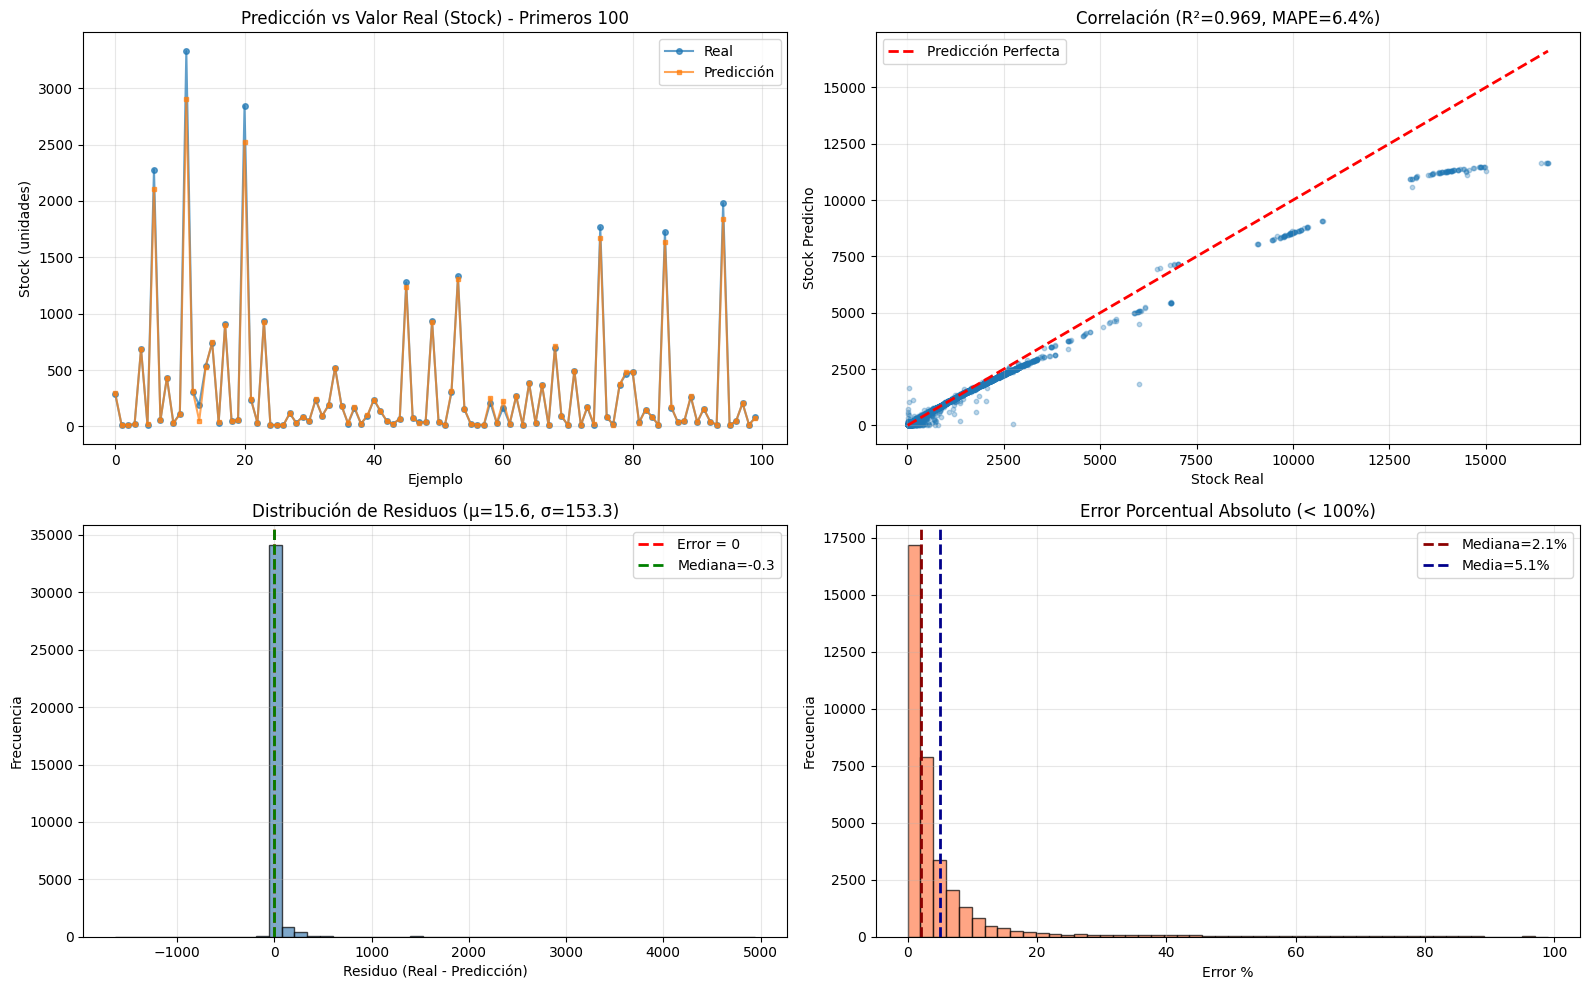


✅ Métricas guardadas en MLflow (Run ID: 21c5f74e642f401286ea035ac3892aa1)


In [16]:
# Evaluar el modelo
print("🔬 Evaluando modelo en conjunto de validación...")
y_pred_log = model.predict([X_val, pid_val], batch_size=256)
y_pred_log = np.asarray(y_pred_log).ravel().astype(np.float32)

# Convertir de escala logarítmica a escala real
y_pred = np.expm1(y_pred_log)  # Inversa de log1p
y_val_real = np.expm1(y_val_log)

# Asegurar que no hay predicciones negativas
y_pred = np.maximum(y_pred, 0)

# Calcular métricas en escala real
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred))
mae = mean_absolute_error(y_val_real, y_pred)
median_ae = np.median(np.abs(y_val_real - y_pred))

# MAPE solo para stock >= 10
threshold = 10
mask_mape = y_val_real >= threshold
if np.sum(mask_mape) > 0:
    mape = np.mean(np.abs((y_val_real[mask_mape] - y_pred[mask_mape]) / y_val_real[mask_mape])) * 100
else:
    mape = 0.0

# R²
r2 = 1 - (np.sum((y_val_real - y_pred)**2) / np.sum((y_val_real - y_val_real.mean())**2))

# Métricas por rangos de stock
mask_bajo = (y_val_real >= 10) & (y_val_real < 50)
mask_medio = (y_val_real >= 50) & (y_val_real < 200)
mask_alto = y_val_real >= 200

print(f"\n📊 Métricas Finales (Predicción de Stock):")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  Median AE: {median_ae:.2f}")
print(f"  MAPE (stock >= {threshold}): {mape:.2f}%")
print(f"  R²: {r2:.4f}")
print(f"\n📈 Precisión por rango:")
if np.sum(mask_bajo) > 0:
    mape_bajo = np.mean(np.abs((y_val_real[mask_bajo] - y_pred[mask_bajo]) / y_val_real[mask_bajo])) * 100
    print(f"  Stock bajo (10-50): MAPE={mape_bajo:.2f}% | N={np.sum(mask_bajo)}")
if np.sum(mask_medio) > 0:
    mape_medio = np.mean(np.abs((y_val_real[mask_medio] - y_pred[mask_medio]) / y_val_real[mask_medio])) * 100
    print(f"  Stock medio (50-200): MAPE={mape_medio:.2f}% | N={np.sum(mask_medio)}")
if np.sum(mask_alto) > 0:
    mape_alto = np.mean(np.abs((y_val_real[mask_alto] - y_pred[mask_alto]) / y_val_real[mask_alto])) * 100
    print(f"  Stock alto (>=200): MAPE={mape_alto:.2f}% | N={np.sum(mask_alto)}")

print(f"\n🔍 Análisis de predicciones:")
print(f"  Rango predicciones: [{y_pred.min():.1f}, {y_pred.max():.1f}]")
print(f"  Rango reales: [{y_val_real.min():.1f}, {y_val_real.max():.1f}]")
print(f"  Media predicciones: {y_pred.mean():.1f}")
print(f"  Media reales: {y_val_real.mean():.1f}")

try:
    with mlflow.start_run(run_id=run.info.run_id):
        mlflow.log_metric('final_rmse', float(rmse))
        mlflow.log_metric('final_mae', float(mae))
        mlflow.log_metric('final_median_ae', float(median_ae))
        mlflow.log_metric('final_mape', float(mape))
        mlflow.log_metric('final_r2', float(r2))
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # Predicción vs Real
        axes[0, 0].plot(y_val_real[:100], 'o-', label='Real', alpha=0.7, markersize=4)
        axes[0, 0].plot(y_pred[:100], 's-', label='Predicción', alpha=0.7, markersize=3)
        axes[0, 0].set_title('Predicción vs Valor Real (Stock) - Primeros 100')
        axes[0, 0].set_xlabel('Ejemplo')
        axes[0, 0].set_ylabel('Stock (unidades)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Scatter plot
        axes[0, 1].scatter(y_val_real, y_pred, alpha=0.3, s=10)
        axes[0, 1].plot([y_val_real.min(), y_val_real.max()], [y_val_real.min(), y_val_real.max()], 
                     'r--', lw=2, label='Predicción Perfecta')
        axes[0, 1].set_xlabel('Stock Real')
        axes[0, 1].set_ylabel('Stock Predicho')
        axes[0, 1].set_title(f'Correlación (R²={r2:.3f}, MAPE={mape:.1f}%)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Distribución de residuos
        residuos = y_val_real - y_pred
        axes[1, 0].hist(residuos, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Error = 0')
        axes[1, 0].axvline(x=np.median(residuos), color='green', linestyle='--', linewidth=2, 
                          label=f'Mediana={np.median(residuos):.1f}')
        axes[1, 0].set_title(f'Distribución de Residuos (μ={residuos.mean():.1f}, σ={residuos.std():.1f})')
        axes[1, 0].set_xlabel('Residuo (Real - Predicción)')
        axes[1, 0].set_ylabel('Frecuencia')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Error porcentual absoluto
        error_pct = np.abs((y_val_real - y_pred) / (y_val_real + 1)) * 100
        error_pct_filtrado = error_pct[error_pct < 100]
        axes[1, 1].hist(error_pct_filtrado, bins=50, edgecolor='black', alpha=0.7, color='coral')
        axes[1, 1].axvline(x=np.median(error_pct_filtrado), color='darkred', 
                          linestyle='--', linewidth=2, label=f'Mediana={np.median(error_pct_filtrado):.1f}%')
        axes[1, 1].axvline(x=np.mean(error_pct_filtrado), color='darkblue', 
                          linestyle='--', linewidth=2, label=f'Media={np.mean(error_pct_filtrado):.1f}%')
        axes[1, 1].set_title(f'Error Porcentual Absoluto (< 100%)')
        axes[1, 1].set_xlabel('Error %')
        axes[1, 1].set_ylabel('Frecuencia')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('prediction_analysis.png', dpi=150, bbox_inches='tight')
        mlflow.log_artifact('prediction_analysis.png')
        plt.show()
        
        print(f"\n✅ Métricas guardadas en MLflow (Run ID: {run.info.run_id})")
        
except Exception as e:
    print(f'⚠️ Error al registrar métricas: {e}')
